# Windsat + TELSEM data
Explore the correlations between the training variables

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from matplotlib.colors import CenteredNorm
from tensorflow.keras.models import load_model

import xarray as xr
import pandas as pd
import numpy as np
import pickle
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__name__), '../..')))

from src.processing import windsat_datacube, model_preprocess, telsem_datacube
from src.model import xy_split
models_path = "../../models/"

# Select ascending (0) or descending (1) pass
swath = 0

In [2]:
#TELSEM ATLAS
telsem_folder = r"../../data\processed\WindsatEmiss"

# Preprocessing of TELSEM atlas:
telsem_ds = telsem_datacube(telsem_folder)

telsem_df = telsem_ds.to_dataframe().dropna().reset_index("month")
telsem_df

month   Emis19V   Emis19H   Emis37V   Emis37H  \
latitude_grid longitude_grid                                                  
4             0                   1  0.838461  0.642331  0.850453  0.687476   
              1                   1  0.838612  0.642670  0.850646  0.687777   
              2                   1  0.838762  0.643009  0.850838  0.688078   
              3                   1  0.838912  0.643348  0.851031  0.688379   
              4                   1  0.839063  0.643688  0.851224  0.688679   
...                             ...       ...       ...       ...       ...   
693           609                12  0.929797  0.854530  0.850951  0.786876   
              610                12  0.929314  0.854520  0.845948  0.783754   
              611                12  0.928832  0.854509  0.840944  0.780632   
              612                12  0.929997  0.855679  0.836587  0.777149   
694           589                12  0.918187  0.844714  0.832307  0.772072   

                                 lat      lon  
latitude_grid longitude_grid                   
4             0              -88.875  180.125  
              1              -88.875  180.375  
              2              -88.875  180.625  
              3              -88.875  180.875  
              4              -88.875  181.125  
...                              ...      ...  
693           609             83.375  332.375  
              610             83.375  332.625  
              611             83.375  332.875  
              612             83.375  333.125  
694           589             83.625  327.375  

[4051772 rows x 7 columns]

In [3]:
# WINDSAT data
folder_path = "../../data/raw/Daily_Windsat/"
ds = windsat_datacube(folder_path)
swath_ds= model_preprocess(ds, swath_sector=swath)

# Select pixels with surtep_ERA5 greater than 2ºC, standard for snow free
swath_ds = swath_ds.where(swath_ds.surtep_ERA5 > (273.15 + 2))

# Select the variables from windsat that we need:
d_vars = [
    "surtep_ERA5",
    "lat",
    "lon",
    "tbtoa_18Ghz_V",
    "tbtoa_18Ghz_H",
    "tbtoa_37Ghz_V",
    "tbtoa_37Ghz_H",
]

swath_ds = swath_ds[d_vars]

swath_df = swath_ds.to_dataframe().dropna().reset_index("day_number")

# Map the day of the year (day_number) into the month:
day_mapping = []
days_in_months = [31,29,31,30,31,30,31,31,30,31,30,31]

for i, n in enumerate(days_in_months):
    to_add = [i +1] * n
    day_mapping.extend(to_add)
len(day_mapping)


swath_df["month"] = swath_df["day_number"].apply(lambda x: day_mapping[x])
# drop the day_number column
swath_df = swath_df.drop(columns="day_number")
swath_df

surtep_ERA5     lat      lon  tbtoa_18Ghz_V  \
latitude_grid longitude_grid                                                
147           1014             275.894440 -53.125   73.625     194.885010   
151           478              286.504700 -52.125  299.625     226.136017   
              481              285.798737 -52.125  300.375     226.611542   
152           480              285.345428 -51.875  300.125     239.678406   
              482              285.551025 -51.875  300.625     240.952301   
...                                   ...     ...      ...            ...   
642           808              279.382294  70.625   22.125     198.187500   
              809              279.180969  70.625   22.375     204.407501   
              810              278.574554  70.625   22.625     208.712494   
              811              276.485809  70.625   22.875     210.847504   
657           796              275.716309  74.375   19.125     192.205002   

                              tbtoa_18Ghz_H  tbtoa_37Ghz_V  tbtoa_37Ghz_H  \
latitude_grid longitude_grid                                                
147           1014               127.485001     215.657501     163.107498   
151           478                181.116562     237.195679     199.574356   
              481                180.978912     238.014069     199.999802   
152           480                204.687469     248.563171     220.121918   
              482                208.183792     249.369049     221.831299   
...                                     ...            ...            ...   
642           808                130.512497     208.532501     153.035004   
              809                142.735001     210.417496     160.252502   
              810                151.412506     212.059998     165.992493   
              811                155.565002     212.977493     169.082489   
657           796                121.514999     213.897491     159.597504   

                              month  
latitude_grid longitude_grid         
147           1014                1  
151           478                 1  
              481                 1  
152           480                 1  
              482                 1  
...                             ...  
642           808                12  
              809                12  
              810                12  
              811                12  
657           796                12  

[1675642 rows x 8 columns]

In [4]:
# Inner join the telsem df and the ascending df
combined_df = pd.merge(left=swath_df, right=telsem_df, how="inner")

# Drop the month column
combined_df = combined_df.drop(columns="month")
combined_df

,surtep_ERA5,lat,lon,tbtoa_18Ghz_V,tbtoa_18Ghz_H,tbtoa_37Ghz_V,tbtoa_37Ghz_H,Emis19V,Emis19H,Emis37V,Emis37H
0,275.894440,-53.125,73.625,194.885010,127.485001,215.657501,163.107498,0.646831,0.384178,0.728075,0.499101
1,286.504700,-52.125,299.625,226.136017,181.116562,237.195679,199.574356,0.766709,0.595761,0.818902,0.673376
2,285.798737,-52.125,300.375,226.611542,180.978912,238.014069,199.999802,0.810449,0.670419,0.834964,0.702682
3,285.345428,-51.875,300.125,239.678406,204.687469,248.563171,220.121918,0.793805,0.642822,0.817769,0.671116
4,285.551025,-51.875,300.625,240.952301,208.183792,249.369049,221.831299,0.800585,0.656406,0.816299,0.671582
...,...,...,...,...,...,...,...,...,...,...,...
1675637,279.382294,70.625,22.125,198.187500,130.512497,208.532501,153.035004,0.669632,0.419112,0.707013,0.448490
1675638,279.180969,70.625,22.375,204.407501,142.735001,210.417496,160.252502,0.670714,0.420704,0.707621,0.449943
1675639,278.574554,70.625,22.625,208.712494,151.412506,212.059998,165.992493,0.671796,0.422296,0.708228,0.451395
1675640,276.485809,70.625,22.875,210.847504,155.565002,212.977493,169.082489,0.672878,0.423889,0.708836,0.452847


In [5]:
X , y = xy_split(combined_df, y_column= "surtep_ERA5")
X

,lat,lon,tbtoa_18Ghz_V,tbtoa_18Ghz_H,tbtoa_37Ghz_V,tbtoa_37Ghz_H,Emis19V,Emis19H,Emis37V,Emis37H
0,-53.125,73.625,194.885010,127.485001,215.657501,163.107498,0.646831,0.384178,0.728075,0.499101
1,-52.125,299.625,226.136017,181.116562,237.195679,199.574356,0.766709,0.595761,0.818902,0.673376
2,-52.125,300.375,226.611542,180.978912,238.014069,199.999802,0.810449,0.670419,0.834964,0.702682
3,-51.875,300.125,239.678406,204.687469,248.563171,220.121918,0.793805,0.642822,0.817769,0.671116
4,-51.875,300.625,240.952301,208.183792,249.369049,221.831299,0.800585,0.656406,0.816299,0.671582
...,...,...,...,...,...,...,...,...,...,...
1675637,70.625,22.125,198.187500,130.512497,208.532501,153.035004,0.669632,0.419112,0.707013,0.448490
1675638,70.625,22.375,204.407501,142.735001,210.417496,160.252502,0.670714,0.420704,0.707621,0.449943
1675639,70.625,22.625,208.712494,151.412506,212.059998,165.992493,0.671796,0.422296,0.708228,0.451395
1675640,70.625,22.875,210.847504,155.565002,212.977493,169.082489,0.672878,0.423889,0.708836,0.452847


In [6]:
# Predict using some of our models:
# Save the original lat lon for plotting later
lat  = combined_df["lat"].copy()
lon = combined_df["lon"].copy()

combined_df["lon"] = combined_df["lon"].apply(lambda x: np.sin(np.deg2rad(x)))
combined_df["lat"] = combined_df["lat"].apply(lambda x: np.sin(np.deg2rad(x)))

# Load a model
datestring = "local_windsatv2_A_2024_06_13T111608"
model_path = os.path.join(models_path, datestring + ".keras")
history_path = os.path.join(models_path, datestring + "_history")

model = load_model(model_path)
model.summary()

# Predict for the local sample and plot:
X, y = xy_split(combined_df, y_column = "surtep_ERA5")
combined_df["surtep_MODEL"] = model.predict(X)
combined_df["error"] = combined_df["surtep_ERA5"] - combined_df["surtep_MODEL"]

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_1           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer1 (Dense)            │ (None, 30)             │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer2 (Dense)            │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer3 (Dense)            │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputLayer (Dense)             │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,595 (14.05 KB)

 Trainable params: 1,191 (4.65 KB)

 Non-trainable params: 20 (80.00 B)

 Optimizer params: 2,384 (9.32 KB)

52364/52364 ━━━━━━━━━━━━━━━━━━━━ 27s 508us/step


In [7]:
# Pearson´s correlaction coefficient.
from sklearn.feature_selection import r_regression

ccoeff = r_regression(X,y)
print("Pearson´s R coeffs")
for i, c in enumerate(ccoeff):
    print(f"{combined_df.columns[i + 1]} : {c:.5f}")

Pearson´s R coeffs
lat : -0.34192
lon : 0.06742
tbtoa_18Ghz_V : 0.70961
tbtoa_18Ghz_H : 0.39367
tbtoa_37Ghz_V : 0.74170
tbtoa_37Ghz_H : 0.45012
Emis19V : 0.13820
Emis19H : 0.02162
Emis37V : 0.10022
Emis37H : 0.01077


The ratio of theese coeafficienst and the ratio of the permutation importances with the trained models are very simmilar. but the emissivities' linear correlation is not as strong as the model importance (non linear relationship ? )

In [108]:
from sklearn.linear_model import LinearRegression

# Reshape the tbtoa_37Ghz_V column to be a 2D array
X = combined_df["tbtoa_37Ghz_V"].values.reshape(-1, 1)
y = combined_df["surtep_ERA5"].values

# Fit the linear regression model
reg = LinearRegression().fit(X, y)

# Evaluate the model
score = reg.score(X, y)
print("Model score:", score)

# Predict using the model
holmes_lst = reg.predict(X)
print("Predictions:", holmes_lst)

print(reg.intercept_, reg.coef_)

Model score: 0.5519631816242492
Predictions: [258.18457 266.48987 268.63995 ... 256.1729  256.68594 257.20038]
137.59207 [0.55918527]


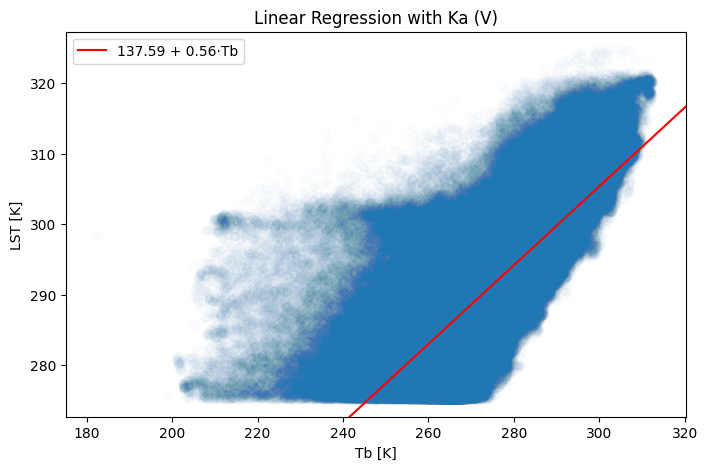

In [109]:
# Scatterplot of the linear regression

fig, ax = plt.subplots(1,1,figsize =(8,5))

# TODO: Density plot
ax.scatter(x=combined_df["tbtoa_37Ghz_V"], y = combined_df["surtep_ERA5"], alpha = 0.01)
# Get the current limits of the axes
xlim = ax.get_xlim()
ylim = ax.get_ylim()

ax.axline((0,reg.intercept_), slope= reg.coef_[0], color = "Red", label = f"{reg.intercept_:.2f} + {reg.coef_[0]:.2f}·Tb")

# Set the limits back to the original ones
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel("Tb [K]")
ax.set_ylabel("LST [K]") 
ax.set_title("Linear Regression with Ka (V)")
ax.legend(loc = "upper left")


In [110]:
# Compare the error histogram of one of the models and Holme´s regression
combined_df["holmes_error"] = combined_df["surtep_ERA5"] - holmes_lst

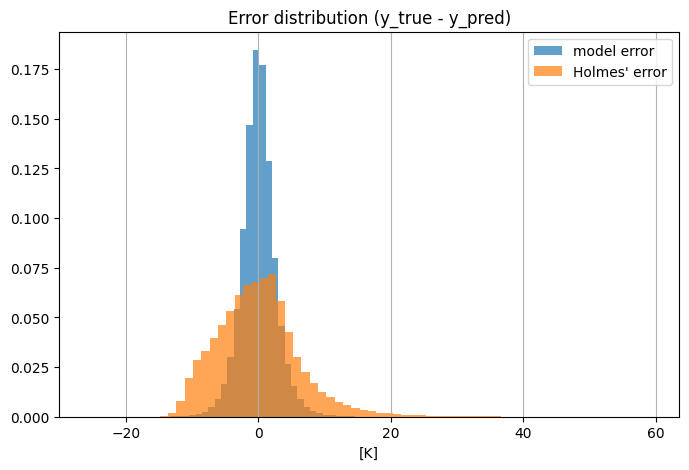

In [111]:
# Error histogram:

# TODO : Change Holmes, names to "Linear Regression"
# Do some plotting to check error distribution
fig, ax = plt.subplots(1,1,figsize = (8,5))

ax.hist(x = combined_df["error"],
    density = True, bins = 60, label = "model error", alpha = 0.7
)
ax.hist(x = combined_df["holmes_error"],
    density = True, bins = 60, label = " Linear regression error", alpha = 0.7
)
ax.grid(axis="x")

# TODO: add holme's parameters etc.

ax.set_title("Error distribution (y_true - y_pred)")
ax.set_xlabel("[K]")
ax.legend()
plt.show()

In [112]:
# Calculate the average error for each pixel (avg in time):
# we re-add lat and lon after the trasnformation
combined_df["lat"] = lat
combined_df["lon"] = lon
combined_df = combined_df.groupby(["lat","lon"]).mean().reset_index()

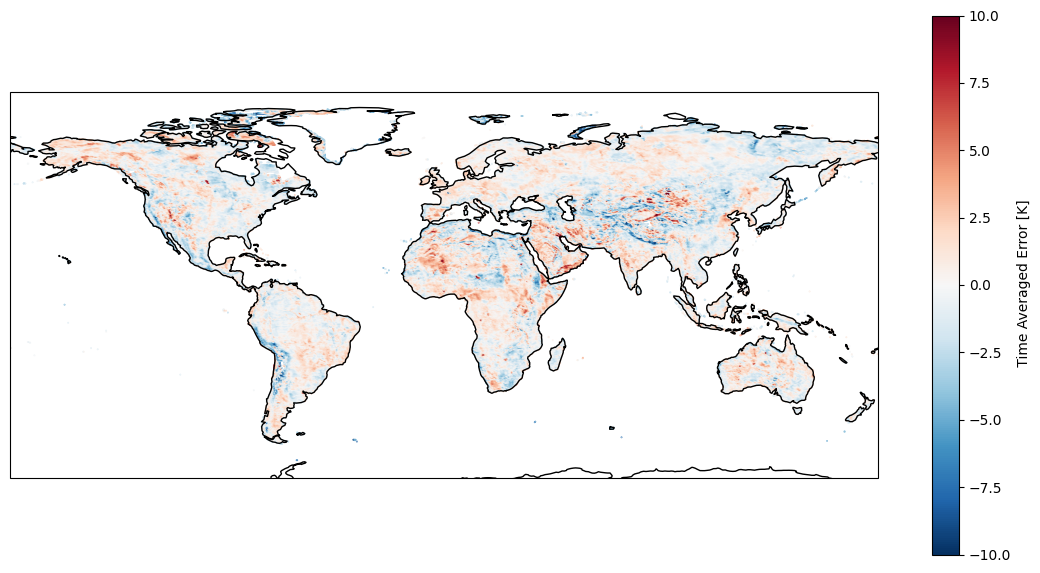

In [115]:
# Error map projections:
# Same norm for both plots
norm = CenteredNorm(vcenter=0,halfrange=10, clip = False)
# MAPS
fig, ax = plt.subplots(1,1,figsize = (14,7), subplot_kw={"projection":ccrs.PlateCarree()} )

ax.coastlines("110m")

scatter = ax.scatter(
    x = combined_df["lon"],
    y = combined_df["lat"],
    s= 0.1,
    alpha = 1,
    c = combined_df["error"],
    cmap = "RdBu_r",
    norm=norm
)

fig.colorbar(scatter, ax=ax, orientation='vertical', label=' Time Averaged Error [K]')
plt.show()

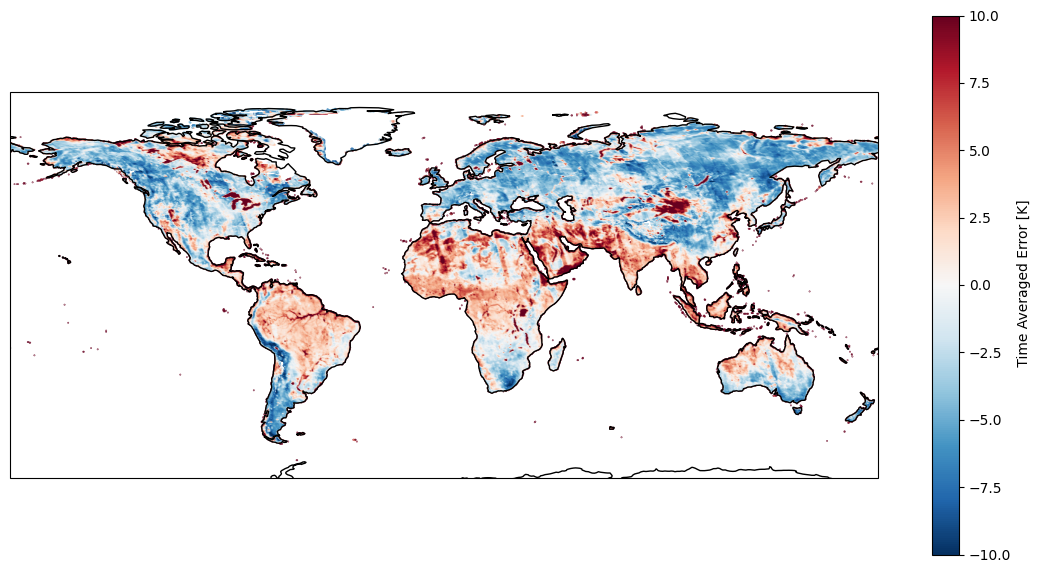

In [116]:
# Error map projections:
# MAPS
fig, ax = plt.subplots(1,1,figsize = (14,7), subplot_kw={"projection":ccrs.PlateCarree()} )
ax.coastlines("110m")

scatter = ax.scatter(
    x = combined_df["lon"],
    y = combined_df["lat"],
    s= 0.1,
    alpha = 1,
    c = combined_df["holmes_error"],
    cmap = "RdBu_r",
    norm=norm
)

fig.colorbar(scatter, ax=ax, orientation='vertical', label=' Time Averaged Error [K]')
plt.show()